In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   


In [3]:
feature_selections = pd.read_pickle("../data/feature_selections.pickle")
firing_rates = pd.read_pickle(f"../data/firing_rates_{pre_interval}_fb_{post_interval}.pickle")

In [8]:
def create_fig_by_splitter(feature_dim, splitter, splitter_name, clf, inputs, labels):
    test_accs_by_bin, shuffled_accs = classifier_utils.evaluate_classifiers_by_time_bins(
        clf, inputs, labels, np.arange(0, 2.8, 0.1), splitter
    )
    np.save(f"../data/{feature_dim}_accs_{pre_interval}_fb_{post_interval}_by_bin_{splitter_name}_split.npy", test_accs_by_bin)
    np.save(f"../data/{feature_dim}_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_{splitter_name}_splitter.npy", test_accs_by_bin)

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
    )
    ax.axvline(-800, color='k')
    plt.savefig(f"../data/accs_{splitter_name}_split_{feature_dim}_{pre_interval}_fb_{post_interval}.png")

Feature dim Color
Generating figs for Block Splitter
28
28
28
28


ValueError: Format 'fig' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

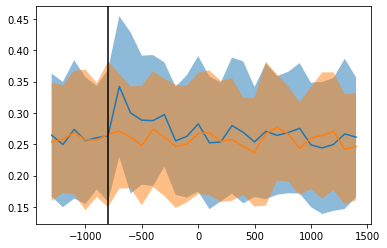

In [7]:
for feature_dim in feature_dims:
    print(f"Feature dim {feature_dim}")
    clf = svm.SVC(decision_function_shape='ovo')
    # Look at Spike Counts instead of Firing Rate
    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})
    # block_splitter = BlockSplitter(valid_beh)
    # print(f"Generating figs for Block Splitter")
    # create_fig_by_splitter(feature_dim, block_splitter, "block", clf, inputs, labels)
    print(f"Generating figs for Random Splitter")
    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
    create_fig_by_splitter(feature_dim, random_splitter, "random", clf, inputs, labels)